# causal inference

In [18]:
import os
import pandas as pd
import numpy as np
import datetime

import requests
from bs4 import BeautifulSoup
import time

#import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False

import statsmodels.formula.api as smf
from scipy import stats

## DiD

In [19]:
raw = pd.read_pickle('./rawdata.pickle')

# 기준 날짜를 datetime.date 형식으로 변환
start_date = datetime.date(2022, 11, 1)

# '서울특별시'와 '부산광역시'에 해당하는 데이터 필터링 후, 필요한 열 선택
df = raw.loc[
    (raw['시도'].map(lambda x: x in ['서울특별시', '부산광역시'])) &
    (raw['일자'] >= start_date),  # 2022-11-01 이후 데이터만 필터링
    ['일자', '시도', '시군구', '목적통행량', 'treated', 'post', 'w']
].copy()
df['일자'] = df['일자'].map(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()))
df = df.reset_index(drop=True)

df.head(3)

,일자,시도,시군구,목적통행량,treated,post,w
0,2022-11-01,부산광역시,강서구,45163,0,0,0
1,2022-11-02,부산광역시,강서구,45933,0,0,0
2,2022-11-03,부산광역시,강서구,46304,0,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26199 entries, 0 to 26198
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일자       26199 non-null  datetime64[ns]
 1   시도       26199 non-null  object        
 2   시군구      26199 non-null  object        
 3   목적통행량    26199 non-null  int64         
 4   treated  26199 non-null  int64         
 5   post     26199 non-null  int64         
 6   w        26199 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.4+ MB


In [21]:
x = '일자'
y = '목적통행량'

df_did = (df.groupby(["treated", "post"])
            .agg({y:"mean", x: ["min", "max"]}))

df_did['목적통행량'] = df_did['목적통행량'].round(1)
df_did

목적통행량         일자           
                  mean        min        max
treated post                                
0       0     107753.9 2022-11-01 2024-01-26
        1     107531.1 2024-01-27 2024-07-31
1       0     305141.6 2022-11-01 2024-01-26
        1     314974.8 2024-01-27 2024-07-31

In [22]:
y0_est = (df_did.loc[1].loc[0, y] # treated baseline(treat 1 / post 0)
          + df_did.loc[0].diff().loc[1,y]) # control group 추세

att = df_did.loc[1].loc[1, y] - y0_est
att

mean    10056.0
dtype: object

In [30]:
# 고정효과 회귀
df = df.rename(columns={'목적통행량':'y'})

m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit()
# m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit(
#     cov_type='cluster', cov_kwds={'groups': df['시도']})

m.params['treated:post'] # 인과 효과 추정량(시군구, 일 단위)

10055.972705695121

In [31]:
# 고정효과 회귀(다중공선성 고려)
df = df.rename(columns={'목적통행량':'y'})

m = smf.ols('y ~ treated:post + C(시군구) + C(일자)', data=df).fit()
# m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit(
#     cov_type='cluster', cov_kwds={'groups': df['시도']})

m.params['treated:post'] # 인과 효과 추정량(시군구, 일 단위)

57408.65761743199

In [24]:
# did: 10055.972705695121

In [25]:
m.conf_int().loc['treated:post'] # 신뢰구간

0    53829.043594
1    60988.271641
Name: treated:post, dtype: float64

# 평행추세가정 검증

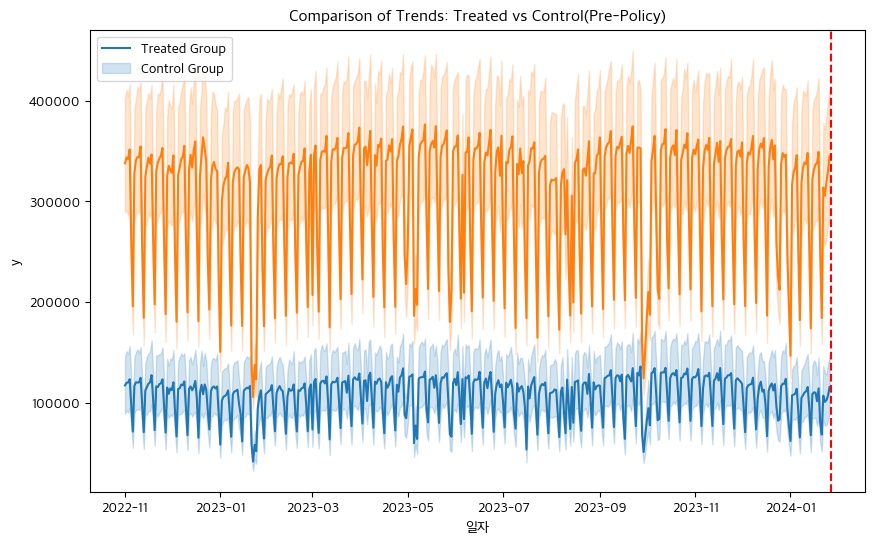

In [26]:
#1)시각적 검증(Pre-treatment기간만)

# 정책 시행 이전 데이터 필터링
pre_data = df[df['post'] == 0]

# 처리 집단과 비처리 집단의 추세 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 정책 도입일자 표기
policy_start_date = pd.to_datetime('2024-01-27') 

plt.figure(figsize=(10, 6))
sns.lineplot(data=pre_data, x='일자', y='y', hue='treated', estimator='mean')
plt.axvline(x=policy_start_date, color='red', linestyle='--', label='Policy Start')
plt.title('Comparison of Trends: Treated vs Control(Pre-Policy)')
plt.legend(['Treated Group', 'Control Group'])
plt.show()

=> 결과: 두 집단이 시간에 따라 동일한 기울기로 증가 또는 감소, 평행추세가정 만족

/var/folders/x6/ym8znrfj3v14qf7twgc36tq80000gn/T/ipykernel_79052/469701118.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='일자', y='y', hue='treated', estimator='mean', ci=None)  # 처리 여부에 따른 추세 그래프


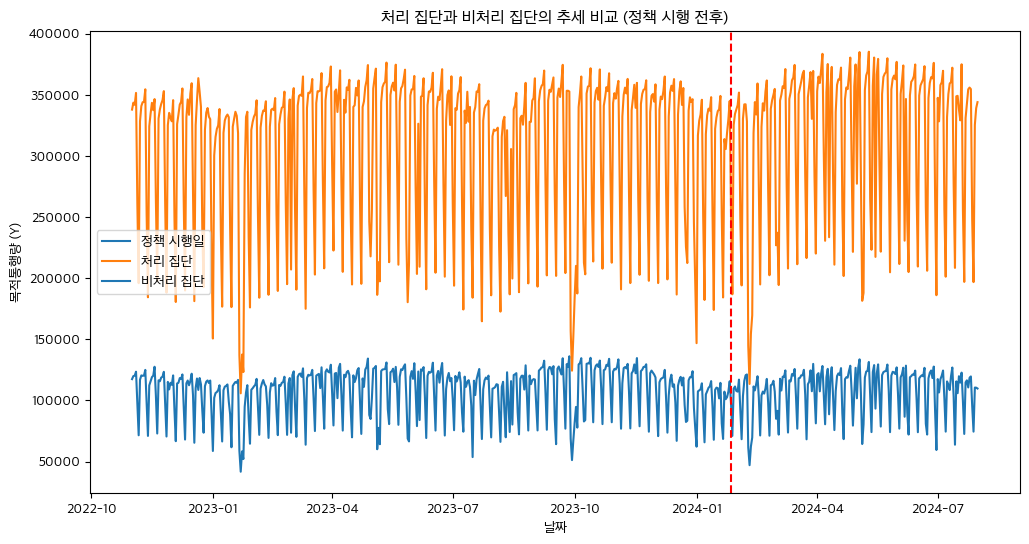

In [28]:
#1)시각적 검증(전체 기간)

# 정책 시행 전후 데이터를 포함한 처리 집단과 비처리 집단의 추세 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='일자', y='y', hue='treated', estimator='mean', ci=None)  # 처리 여부에 따른 추세 그래프

# 정책 시행일을 기준으로 수직선 추가
plt.axvline(x=policy_start_date, color='red', linestyle='--', label='정책 시행일')  # 정책 시행일 기준선

# 제목 및 축 레이블 추가
plt.title('처리 집단과 비처리 집단의 추세 비교 (정책 시행 전후)')
plt.xlabel('날짜')
plt.ylabel('목적통행량 (Y)')
plt.legend(['정책 시행일', '처리 집단', '비처리 집단'])  # 범례 추가
plt.show()

In [29]:
#2) Placebo 테스트

# 정책 시행 이전 데이터를 기반으로 Placebo 분석(임의의 날짜 설정)
placebo_date = pd.to_datetime('2023-11-01')  # 임의의 가상 정책 도입일
pre_data['placebo_post'] = pre_data['일자'] >= placebo_date

# 3. Placebo Test를 위한 DID 회귀모델 생성
model = smf.ols('y ~ treated * placebo_post + C(시군구)', data=pre_data).fit()

# 4. 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     2597.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:34:17   Log-Likelihood:            -2.3052e+05
No. Observations:               18532   AIC:                         4.611e+05
Df Residuals:                   18490   BIC:                         4.615e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/var/folders/x6/ym8znrfj3v14qf7twgc36tq80000gn/T/ipykernel_79052/2965563208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_data['placebo_post'] = pre_data['일자'] >= placebo_date


=> p-value: 0.098 (유의수준 10%에서는 유의, 5%에서는 유의하지 않음)
처리 집단과 비처리 집단 간의 변화가 통계적으로 유의하지 않다고 볼 수 있음.
해석: Placebo 정책 시행 이후 두 집단 간의 추세 변화는 유의미하지 않으므로, 평행추세 가정이 대체로 성립한다고 볼 수 있습니다.